In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.ion() # (%matplotlib inline)
import os

# Patch Perfect

This notebook will document the process we underwent to find a solution to the plothole-problem.


### EDA

We start by looking at the data systematically to see where we will inevitably need to solve problems before we create a model:

In [2]:
# __file__ = os.path.abspath('') # notebooks are stupid
# DATA_DIR = Path(__file__).resolve() / "data"
# TRAIN_LABELS_PATH = DATA_DIR / "train_labels.csv"

# train_label_df = pd.read_csv(filepath_or_buffer=TRAIN_LABELS_PATH)
# train_label_df.rename(columns={'Bags used ': 'Bags used'}, inplace=True)

In [3]:
# values = train_label_df.loc[:, 'Bags used'].value_counts()
# plt.figure(figsize=(10, 6))
# plt.hist(values, bins=range(1, max(values) + 2), edgecolor='black')
# plt.title('Histogram of Data Points per Bag Amount')
# plt.xlabel('Number of Data Points for Each Bag Amount')
# plt.ylabel('Frequency')
# plt.grid(True)


We can see that there is a massive class imbalance. This could create issues where a model trained on this dataset has a bias towards more common bags. Most values are between 0 and 1 with some values much higher. There are many strategies we could use to solve this, including but not limited to:
<ul>
<li>Some label abstraction technique where we might create labels based on a logarithmic scale</li>
<li>Data augmentation as a class imbalance mitigation: This process is called upsampling</li>
</ul>

We should also consider the following: The data makes this problem seem like a regression model is needed, but tuning the labels may enable us to change it to a much simpler classification task at the cost of some accuracy. Doing this would result in a much more robust model and enable us to use techniques like label smoothing to let the model generalize more to unseen data.
<hr>
References:
<ul>
<li>Paperspace Blog. (2022). Data Augmentation: A Class Imbalance Mitigative Measure. [online] Available at: https://blog.paperspace.com/data-augmentation-a-class-imbalance-mitigative-measure/.</li>
<li>S. Wang and X. Yao, "Multiclass Imbalance Problems: Analysis and Potential Solutions," in IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 42, no. 4, pp. 1119-1130, Aug. 2012, doi: 10.1109/TSMCB.2012.2187280. keywords: {Training;Correlation;Training data;Pattern analysis;Genetic algorithms;IEEE Potentials;Cybernetics;Boosting;diversity;ensemble learning;multiclass imbalance problems;negative correlation learning}, </li>
</ul>
‌

## The model

In [4]:
import torch
from torch import nn
model = torch.load("./pretrained_model.pt")

for name, param in model.named_parameters():
    if("bn" not in name):
      param.requires_grad = False


model.classifier = nn.Sequential( # Change only the classifier of the model, I.E the last few layers

    nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Dropout(p=0.1, inplace=False),
    nn.Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1)) # Change the output to 3 classes instead of 21

)


/tmp/ipykernel_560002/3933020813.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./pretrained_model.pt")


In [5]:
trainable_layers = 0
non_trainable_layers = 0

for name, module in model.named_modules():
    # Check if any parameter in the layer requires gradients
    if any(param.requires_grad for param in module.parameters()):
        trainable_layers += 1
    else:
        non_trainable_layers += 1

print(f"Trainable layers: {trainable_layers}")
print(f"Non-trainable layers: {non_trainable_layers}")


Trainable layers: 75
Non-trainable layers: 87


In [6]:

trainable_params = 0
non_trainable_params = 0

for param in model.parameters():
    if param.requires_grad:
        trainable_params += param.numel()  # Count the number of elements
    else:
        non_trainable_params += param.numel()

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Trainable parameters: 9485187
Non-trainable parameters: 25827797


## Training Code

In [7]:
import torch.optim as optim
from torchvision.utils import save_image


# optimizer = optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=0.001
# )



def train_model(model, train_loader, val_loader, num_epochs=1):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 3e-4) # Karpathy's number

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.type(torch.LongTensor).cuda()
                model.cuda()


            # Forward pass
            outputs = model(images)['out']

            loss = criterion(outputs, labels)

            # Zero gradients
            optimizer.zero_grad()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            #running_loss += loss.item() * images.size(0)
        test_loss = evaluate_model(model, val_loader)
        #epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {test_loss:.4f}')

def evaluate_model(model, val_loader):
    model.eval()
    total_correct = 0
    total_pixels = 0
    with torch.no_grad():
        for images, labels in val_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)['out']
            _, preds = torch.max(outputs, 1)

            total_pixels += labels.numel()
            total_correct += (preds == labels).sum().item()

        accuracy = total_correct / total_pixels
        return accuracy
        #print(f'Validation Accuracy: {accuracy:.4f}')


## Data Prep Code

In [8]:
# Custom dataset class for your data
import torchvision.transforms as transforms
import random

import torch
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import numpy as np

rgb_to_class = {
    (0, 0, 0): 0,
    (255, 255, 255): 1,
    (100, 100, 100): 2
}

class JointTransform:
    def __init__(self, image_transforms=None, mask_transforms=None):
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
    @staticmethod
    def set_seed(seed):
      torch.manual_seed(seed)
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
      random.seed(seed)
      np.random.seed(seed)

      # Ensure that all operations are deterministic
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
    def __call__(self, image, mask):
        if self.image_transforms:
            seed = random.randint(0, 2**32)
            self.set_seed(seed)
            image = self.image_transforms(image)

            self.set_seed(seed)
            mask = self.mask_transforms(mask)

        return image, mask

image_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
])

mask_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
])

# Instantiate joint transform
augmentation = JointTransform(image_transforms=image_augmentations, mask_transforms=mask_augmentations)


class Potholes(Dataset):
    def __init__(self, image_dir, label_dir, do_augmentation = True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = os.listdir(image_dir)
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)
        self.do_augmentation = do_augmentation

    def __len__(self):
        return len(self.image_filenames)

    @staticmethod
    def rgb_to_mask(mask):
        # Convert the mask to a numpy array
        mask = np.array(mask)

        # Initialize an array to hold the class indices
        class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

        # Apply the mapping from RGB values to class indices
        for rgb, class_index in rgb_to_class.items():
            matches = np.all(mask == rgb, axis=-1)
            class_mask[matches] = class_index

        return class_mask

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, (img_name[:-4] + "_mask.png"))

        # Load image and label
        image = Image.open(img_path)
        mask = Image.open(label_path).convert("RGB")

        # Apply augmentations then transformations

        if self.do_augmentation: image, mask = augmentation(image, mask)

        image, mask = self.image_transforms(image, mask)

        return image, mask

# Define transforms for data augmentation and normalization

    def image_transforms(self, image, label):
        transform_images = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize to the desired input size
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

        transform_labels = transforms.Compose([
            transforms.Resize((256, 256))
        ])
        mask = self.rgb_to_mask(transform_labels(label))
        return transform_images(image), mask




# Paths to your dataset
train_image_dir = "./data/train_images_segmented/"
train_label_dir = "./data/train_masks_segmented/"

val_image_dir = "./data/validation set/"
val_label_dir = "./data/validation masks/"

# size of stick/image indicates camera zoom


In [9]:
# Create datasets and data loaders
train_dataset = Potholes(train_image_dir, train_label_dir, do_augmentation=True)
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)

val_dataset = Potholes(val_image_dir, val_label_dir, do_augmentation=False)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=True)

#train_model(model = model,train_loader = train_loader,num_epochs= 1000, val_loader=val_loader)

In [10]:

import math
import torch

def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0):
    model.to("cuda")
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = float('inf')
    batch_num = 0
    losses = []
    log_lrs = []

    for data in train_loader:
        batch_num += 1
        inputs, labels = data
        inputs, labels = inputs, labels
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)["out"]
        loss = loss_fn(outputs, labels.type(torch.LongTensor).cuda())

        # Convert loss to float for comparison and storage
        loss_value = loss.item()

        # Crash out if loss explodes
        if batch_num > 1 and loss_value > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss
        if loss_value < best_loss:
            best_loss = loss_value

        # Store the values
        losses.append(loss_value)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return log_lrs[10:-5], losses[10:-5]


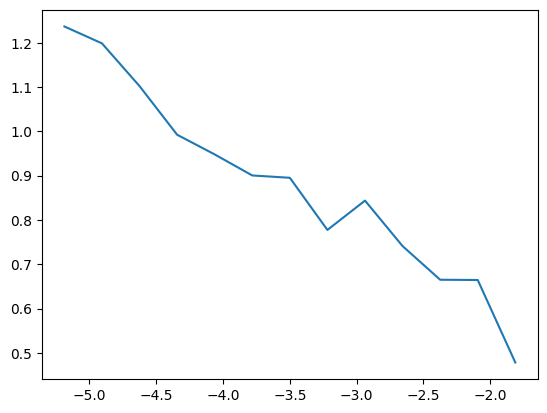

In [11]:
logs,losses = find_lr(model, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr = 3e-4), train_loader=train_loader)
plt.plot(logs,losses)
